In this project, we will be working on extracting text from images. After **extracting the text** we will apply some basic functions of OpenCV on that text to enhance it and to get more accurate results. This project will be very useful as it will save time and effort of typing from an image.

In [ ]:
#import requests to install tesseract
import requests

We will importing request library for fetching the url for git files and images.


In [ ]:
# Downloading tesseract-ocr file
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream = True)

# Writing data to file to avoid path isuues
with open("/usr/share/tesseract-ocr/4.00/tessdata/ind.traineddata", "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
         if block:
             file.write(block)

We will now download tesseract which is required for pytesseract library to run and save the file at the path in open() function.

In [ ]:
# Installing libraries required for optical character recognition
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev

# Importing IPython to clear output which is not important
from IPython.display import HTML, clear_output
clear_output()

In this step we will install the required libraries for ocr and we will also import IPython fucntions to clear the undesired.

In [ ]:
# Installing pytesseract and opencv
! pip install pytesseract wand opencv-python
clear_output()

Now we will install pytesseract and opencv libraries.

In [ ]:
# Import libraries
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

Importing required libraries

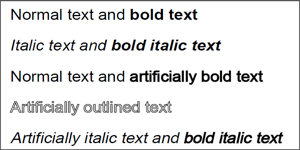

In [ ]:
# Reading image form url
image = Image.open(requests.get('https://i.stack.imgur.com/pbIdS.png', stream=True).raw)
image = image.resize((300,150))
image.save('sample.png')
image

In this step we will, open an image resize it and then again save it for further use and visualize it.

In [ ]:
# Simply extracting text from image
custom_config = r'-l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image,config=custom_config)
print(text)

Normal text and bold text

Italic text and bold italic text

Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text



Here we will be extracting the text from image with custom configuration.

In [ ]:
# Extracting text from image and removing irrelevant symbols from characters
try:
  text=pytesseract.image_to_string(image,lang="eng")
  characters_to_remove = "!()@—*“>+-/,'|£#%$&^_~"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except IOError as e:
    print("Error (%s)." % e)

 

 

Normal text and bold text

Italic text and bold italic text

Normal text and artificially bold text
Artificially outlined text

Artificially italic text and bold italic text

 

 



Now we will remove unwanted symbols from the text we extracted by replacing the symbol with an empty string.

In [ ]:
# Now we will perform opencv operations to get text from complex images
image = cv2.imread('sample.png')

In above cell, we are reading the image into opencv format to process it further. This is required when we need to extract the text from complex images.

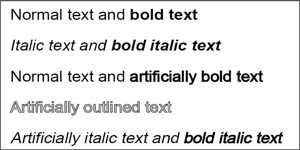

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

Converting the images to grayscale so that it becomes less complex to process as it will have only two values 0 and 1. cv2.cvtColor() method is used to convert an image from one color space to another. There are more than 150 color-space conversion methods available in OpenCV.

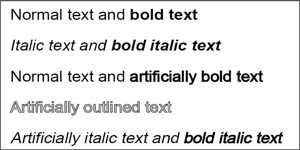

In [ ]:
# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
noise = remove_noise(gray)
Image.fromarray(gray)

Now we will blur the image so that we can remove the noise from the image. Here, the function cv2.medianBlur() computes the median of all the pixels under the kernel window and the central pixel is replaced with this median value. This is highly effective in removing noise.

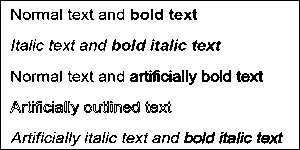

In [ ]:
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)

We will perform threshold transformation here.
cv2. If pixel value is greater than a threshold value, it is assigned one value (may be white), else it is assigned another value (may be black). The function used is cv2.threshold. First argument is the source image, which should be a grayscale image.


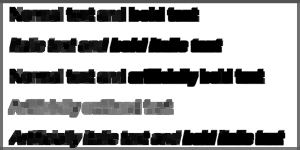

In [ ]:
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)
erode = erode(gray)
Image.fromarray(erode)

Here we are doing erode transformation.
cv2.erode() method is used to perform erosion on the image. The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white). It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation.

In [ ]:
#Morphology
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
opening = opening(gray)
Image.fromarray(opening)

Here we will perform morphological trandformation. It is useful in opening small holes inside the foreground objects, or small white points on the object.

In [ ]:
#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)
canny = canny(gray)
Image.fromarray(canny)

Canny transformation is used to detect egdes in the image.

In [ ]:
#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

Now we will apply deskewing on the image. Deskewing is a process whereby skew is removed by rotating an image by the same amount as its skew but in the opposite direction. This results in a horizontally and vertically aligned image where the text runs across the page rather than at an angle.

In [ ]:
#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

Here we are trying to match the image. As we are passing same image for matching we got the similarity of 99.99%. Here, template matching is a method for searching and finding the location of a template image in a larger image. OpenCV comes with a function cv2.matchTemplate() for this purpose. It simply slides the template image over the input image (as in 2D convolution) and compares the template and patch of input image under the template image.  

In [ ]:
# Drawing rectangle around text
img = cv2.imread('sample.png')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

Now we will segregate every character in the text by creating a rectangle around it.

In [ ]:
# Drawing pattern on specific pattern or word
img = cv2.imread('sample.png')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'artificially'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(date_pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
Image.fromarray(img)

Similarly we can draw rectangle around the specific pattern or word.

# Conclusion:

We started with learning how to install tesseract which is the used for text extraction. Next we took an image and extracted the text from that image. We learned that we need to use certain image transformation function of OpenCV in order to extract text from complex images.


## Scope:

Different organization can use this to extract useful information from the image and store it. Individuals can use it for saving their time and effort for typing.